# chap 13

In [1]:
!nvidia-smi

Sat Jun 15 22:25:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:60:00.0 Off |                    0 |
| N/A   48C    P0              78W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 784  # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [8]:
import os

os.chdir('/mnt/bn/tob-lq/qianweishuo/pytorchTutorial')
os.getcwd()

'/mnt/bn/tob-lq/qianweishuo/pytorchTutorial'

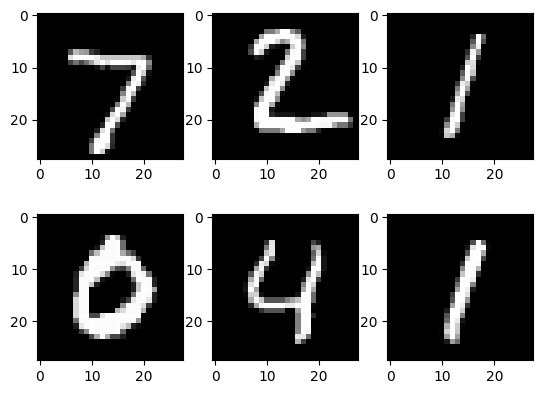

In [9]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [21]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes) -> None:
        super().__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hidden = self.relu(self.l1(x))
        out_logits = self.l2(hidden)
        return out_logits


model = NeuralNet(input_size, hidden_size, num_classes).to(device)  # 记得模型也要放GPU
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [22]:
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        y_pred_logits = model(images.view(-1, 28 * 28).to(device))
        loss = criterion(y_pred_logits, labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % 100 == 0:
            print(f'epoch: {epoch+1:03}/{num_epochs}, step: {i+1:03}/{total_steps}, loss={loss:.4f}')

epoch: 001/2, step: 001/600, loss=2.3144
epoch: 001/2, step: 101/600, loss=0.4454
epoch: 001/2, step: 201/600, loss=0.2587
epoch: 001/2, step: 301/600, loss=0.1195
epoch: 001/2, step: 401/600, loss=0.3096
epoch: 001/2, step: 501/600, loss=0.2939
epoch: 002/2, step: 001/600, loss=0.1365
epoch: 002/2, step: 101/600, loss=0.1002
epoch: 002/2, step: 201/600, loss=0.1806
epoch: 002/2, step: 301/600, loss=0.0945
epoch: 002/2, step: 401/600, loss=0.1346
epoch: 002/2, step: 501/600, loss=0.0699


In [23]:
import numpy as np

is_same_list = []
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        y_pred_test_logits = model(images.view(-1, 28 * 28).to(device))
        _, y_pred_test_labels = y_pred_test_logits.max(dim=1)
        is_same_list += (y_pred_test_labels.cpu() == labels).numpy().tolist()
    acc = np.mean(is_same_list)
    print(f'Accuracy of the network on the {len(test_dataset)} test images: {acc:.4f}')

Accuracy of the network on the 10000 test images: 0.9664


In [18]:
!python3 ./13_feedforward.py

Figure(640x480)
Epoch [1/2], Step [100/600], Loss: 0.3655
Epoch [1/2], Step [200/600], Loss: 0.3345
Epoch [1/2], Step [300/600], Loss: 0.1710
Epoch [1/2], Step [400/600], Loss: 0.2343
Epoch [1/2], Step [500/600], Loss: 0.1235
Epoch [1/2], Step [600/600], Loss: 0.1988
Epoch [2/2], Step [100/600], Loss: 0.1591
Epoch [2/2], Step [200/600], Loss: 0.0902
Epoch [2/2], Step [300/600], Loss: 0.0925
Epoch [2/2], Step [400/600], Loss: 0.1278
Epoch [2/2], Step [500/600], Loss: 0.0646
Epoch [2/2], Step [600/600], Loss: 0.0340
Accuracy of the network on the 10000 test images: 97.05 %


# chap 14

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 5
batch_size = 4
learning_rate = 0.001

100%|██████████| 170498071/170498071 [00:18<00:00, 9255362.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


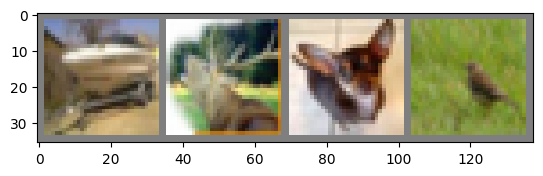

In [25]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5  # unnormalize; -1~1 -> 0~1
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
!python3 ./14_cnn.py

Files already downloaded and verified
Files already downloaded and verified
Figure(640x480)
Epoch [1/5], Step [2000/12500], Loss: 2.2921
Epoch [1/5], Step [4000/12500], Loss: 2.2831
Epoch [1/5], Step [6000/12500], Loss: 2.3142
Epoch [1/5], Step [8000/12500], Loss: 2.3094
Epoch [1/5], Step [10000/12500], Loss: 2.2148
Epoch [1/5], Step [12000/12500], Loss: 2.0976
Epoch [2/5], Step [2000/12500], Loss: 1.8975
Epoch [2/5], Step [4000/12500], Loss: 2.0559
Epoch [2/5], Step [6000/12500], Loss: 1.3797
Epoch [2/5], Step [8000/12500], Loss: 1.4408
Epoch [2/5], Step [10000/12500], Loss: 1.5714
Epoch [2/5], Step [12000/12500], Loss: 1.5705
Epoch [3/5], Step [2000/12500], Loss: 1.4606
Epoch [3/5], Step [4000/12500], Loss: 1.4969
Epoch [3/5], Step [6000/12500], Loss: 1.9228
Epoch [3/5], Step [8000/12500], Loss: 1.7543
Epoch [3/5], Step [10000/12500], Loss: 1.5037
Epoch [3/5], Step [12000/12500], Loss: 1.3311
Epoch [4/5], Step [2000/12500], Loss: 2.6084
Epoch [4/5], Step [4000/12500], Loss: 1.3136
Ep

In [34]:
class ConvNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # x.shape = n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)  # n, 400
        x = F.relu(self.fc1(x))  # n, 120
        x = F.relu(self.fc2(x))  # n, 84
        x = self.fc3(x)  # n, 10
        return x  # 注意最后返回的是 logits, 无激活


model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

In [36]:
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        y_pred_logits = model(images.to(device))
        loss = criterion(y_pred_logits, labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 2000 == 0:  # 注意 loss后面要写.item()
            print(f'epoch: {epoch+1}/{num_epochs}, step: {i+1}/{total_steps}, loss={loss.item():.4f}')

epoch: 1/5, step: 2000/12500, loss=2.2147
epoch: 1/5, step: 4000/12500, loss=2.0189
epoch: 1/5, step: 6000/12500, loss=1.8631
epoch: 1/5, step: 8000/12500, loss=2.2838
epoch: 1/5, step: 10000/12500, loss=1.2833
epoch: 1/5, step: 12000/12500, loss=1.4194
epoch: 2/5, step: 2000/12500, loss=2.0785
epoch: 2/5, step: 4000/12500, loss=1.6651
epoch: 2/5, step: 6000/12500, loss=1.3085
epoch: 2/5, step: 8000/12500, loss=1.4190
epoch: 2/5, step: 10000/12500, loss=2.9948
epoch: 2/5, step: 12000/12500, loss=1.3528
epoch: 3/5, step: 2000/12500, loss=1.8644
epoch: 3/5, step: 4000/12500, loss=1.2737
epoch: 3/5, step: 6000/12500, loss=2.0428
epoch: 3/5, step: 8000/12500, loss=1.4947
epoch: 3/5, step: 10000/12500, loss=1.2659
epoch: 3/5, step: 12000/12500, loss=1.3423
epoch: 4/5, step: 2000/12500, loss=0.7756
epoch: 4/5, step: 4000/12500, loss=1.4120
epoch: 4/5, step: 6000/12500, loss=1.0420
epoch: 4/5, step: 8000/12500, loss=1.7986
epoch: 4/5, step: 10000/12500, loss=2.1456
epoch: 4/5, step: 12000/125

In [37]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(obj=model.state_dict(), f=PATH)

Finished Training


In [39]:
with torch.no_grad():
    n_samples, n_correct = 0, 0
    n_class_samples, n_class_correct = [0] * 10, [0] * 10
    for i, (images, labels) in enumerate(test_loader):
        y_pred_test_logits = model(images.to(device))
        _, y_pred_test_labels = y_pred_test_logits.max(dim=1)
        n_samples += labels.size(0)
        n_correct += y_pred_test_labels.cpu().eq(labels).sum().item()

        for l, p in zip(labels, y_pred_test_labels):
            n_class_samples[l] += 1
            n_class_correct[l] += int(l == p)

print(f'Accuracy of the network: {n_correct / n_samples:.2%}')

for i in range(10):
    acc = n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of the class {classes[i]}: {acc:.2%}')

Accuracy of the network: 50.53%
Accuracy of the class plane: 68.40%
Accuracy of the class car: 73.40%
Accuracy of the class bird: 33.50%
Accuracy of the class cat: 34.70%
Accuracy of the class deer: 31.30%
Accuracy of the class dog: 33.90%
Accuracy of the class frog: 73.30%
Accuracy of the class horse: 52.30%
Accuracy of the class ship: 52.50%
Accuracy of the class truck: 52.00%
